Predicting Factors effecting heart disease using Random Forest Classifier 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
data=pd.read_csv('heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [5]:
data['sex'][data['sex'] == 0] = 'female'
data['sex'][data['sex'] == 1] = 'male'

data['chest_pain_type'][data['chest_pain_type'] == 1] = 'typical angina'
data['chest_pain_type'][data['chest_pain_type'] == 2] = 'atypical angina'
data['chest_pain_type'][data['chest_pain_type'] == 3] = 'non-anginal pain'
data['chest_pain_type'][data['chest_pain_type'] == 4] = 'asymptomatic'

data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
data['fasting_blood_sugar'][data['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

data['rest_ecg'][data['rest_ecg'] == 0] = 'normal'
data['rest_ecg'][data['rest_ecg'] == 1] = 'ST-T wave abnormality'
data['rest_ecg'][data['rest_ecg'] == 2] = 'left ventricular hypertrophy'

data['exercise_induced_angina'][data['exercise_induced_angina'] == 0] = 'no'
data['exercise_induced_angina'][data['exercise_induced_angina'] == 1] = 'yes'

data['st_slope'][data['st_slope'] == 1] = 'upsloping'
data['st_slope'][data['st_slope'] == 2] = 'flat'
data['st_slope'][data['st_slope'] == 3] = 'downsloping'

data['thalassemia'][data['thalassemia'] == 1] = 'normal'
data['thalassemia'][data['thalassemia'] == 2] = 'fixed defect'
data['thalassemia'][data['thalassemia'] == 3] = 'reversable defect'

In [6]:
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [7]:
data['sex']=data['sex'].astype('object')
data['chest_pain_type'] = data['chest_pain_type'].astype('object')
data['fasting_blood_sugar'] = data['fasting_blood_sugar'].astype('object')
data['rest_ecg'] = data['rest_ecg'].astype('object')
data['exercise_induced_angina'] = data['exercise_induced_angina'].astype('object')
data['st_slope'] = data['st_slope'].astype('object')
data['thalassemia'] = data['thalassemia'].astype('object')
data.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [8]:
data=pd.get_dummies(data,drop_first=True)

In [9]:
data.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', 1), data['target'], test_size = .3, random_state=10)

In [11]:
model=RandomForestClassifier(max_depth=6)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [13]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [14]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[36, 14],
       [ 6, 35]], dtype=int64)

In [15]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8571428571428571
Specificity :  0.7142857142857143


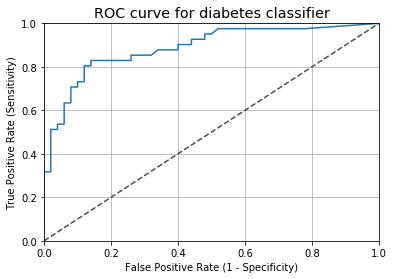

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [17]:
auc(fpr, tpr)

0.8880487804878048

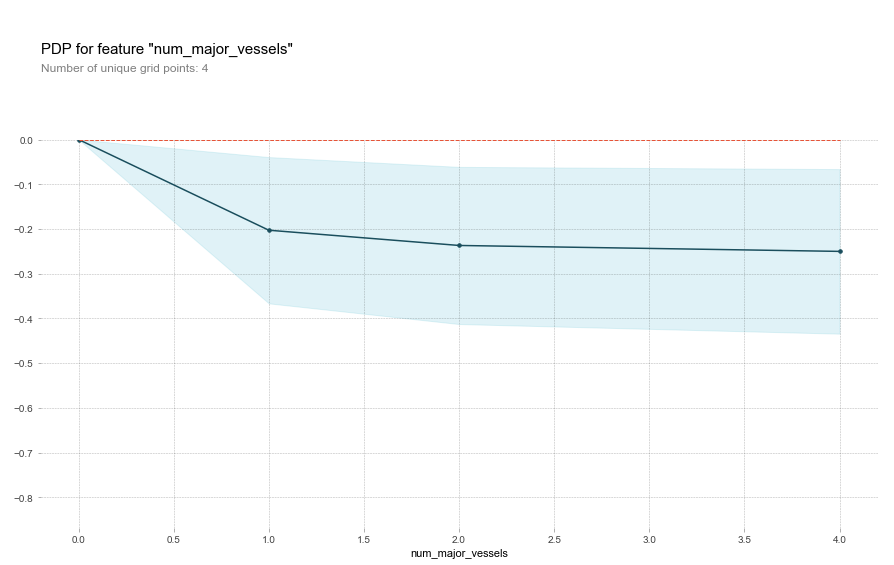

In [20]:
base_features = data.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()


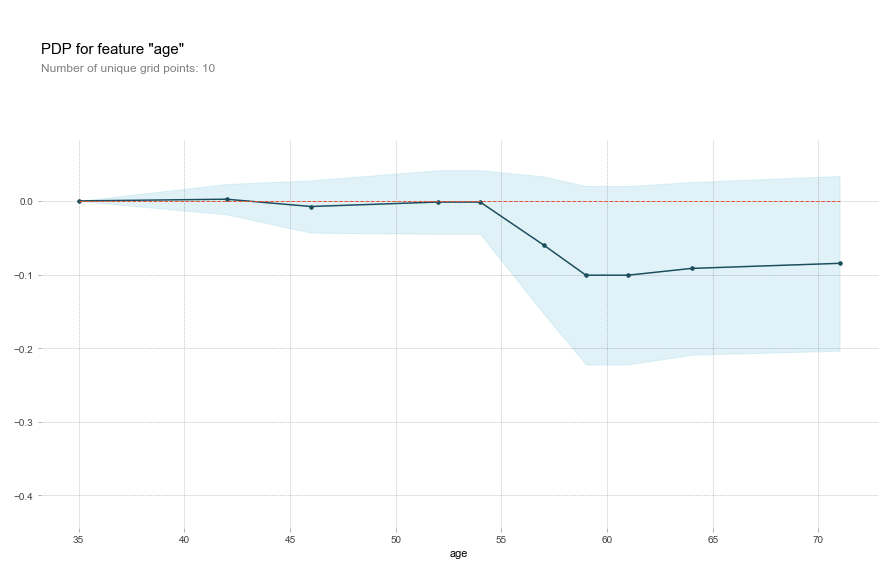

In [21]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

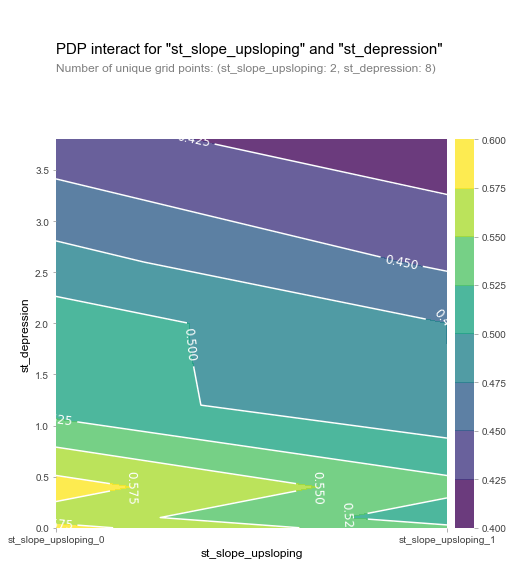

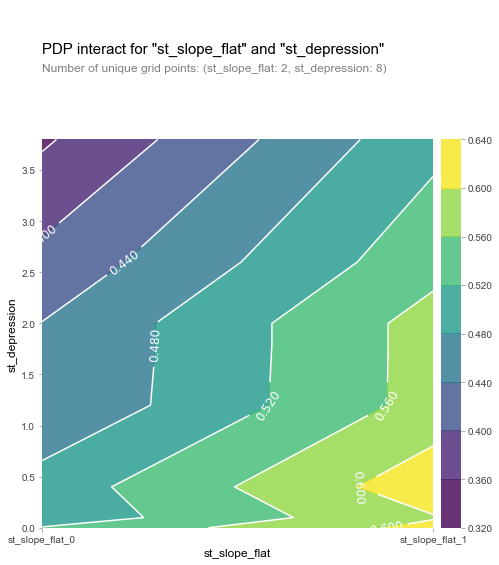

In [24]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()